In [2]:
import random
import imutils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

In [3]:
let = cv2.imread('data/letterlist.jpg', 0)
let = let[15:780,:]
num_letters = 33
num_fonts = 21

In [4]:
type(let), let.shape

(numpy.ndarray, (765, 795))

In [5]:
let.shape[0]//33, let.shape[1]//33

(23, 24)

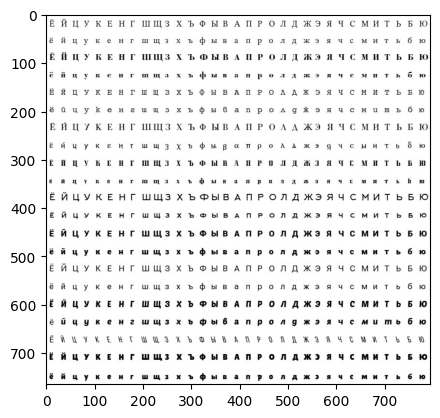

In [6]:
plt.imshow(let, cmap='gray')

(36, 24)


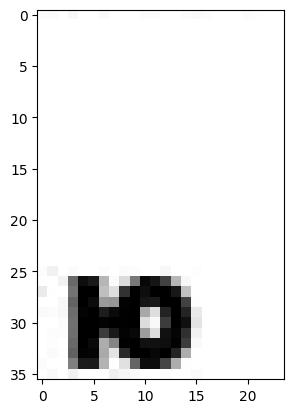

In [7]:
def get_letter(font_num, letter_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]
test = get_letter(21,33)
print(test.shape)
plt.imshow(test, cmap='gray')

In [8]:
def get_letter_variants(letter_num):
        return let[:,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]

def get_font_variants(font_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           :,
           ]

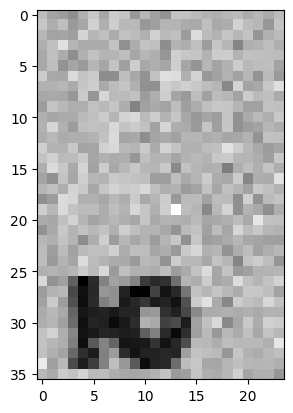

In [9]:
class BaseAugmenter():
    def __init__(self, chanse=0.5):
        self.chance = chanse
        
    def __call__(self, img, *args, **kwargs):
        if random.random()<= self.chance:
            img = self._apply(img, *args, **kwargs)
        return img
    
    def _apply(self, img, *args, **kwargs):
        return img
    
class NoiseAugmenter(BaseAugmenter):
    def _apply(self, letter, max=30):
        noise = np.random.normal(size=(letter.shape))*max
        return letter+noise
    
plt.imshow(NoiseAugmenter(1)(test), cmap='gray')

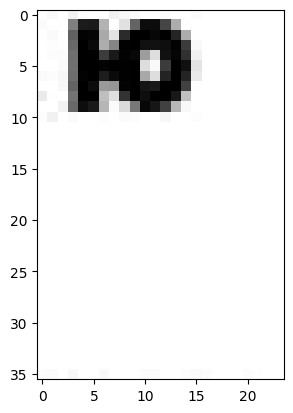

In [10]:
class FlipAugmenter(BaseAugmenter):

    def _apply(self, letter, mode='horizontal'):
        if mode == 'horizontal':
            return np.flip(letter, axis=0)
        elif mode == 'vertical':
            return np.flip(letter, axis=1)
        elif mode == 'random':
            axis = random.random() < 0.5
            return np.flip(letter, axis=int(axis))
        
plt.imshow(FlipAugmenter(1)(test), cmap='gray')  

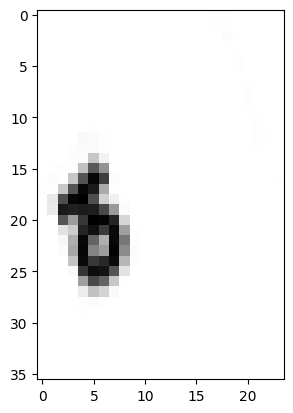

In [11]:
class RotationAugmenter(BaseAugmenter):
    
    def _apply(self, letter, angle=60):
        image = np.zeros_like(letter) + 255 - letter
        rotated = imutils.rotate_bound(image, angle)
        rotated = np.zeros_like(rotated) + 255 - rotated
        rotated = cv2.resize(rotated, (letter.shape[1], letter.shape[0]))
        return rotated
rotated = RotationAugmenter(1)(test)
plt.imshow(rotated, cmap='gray')

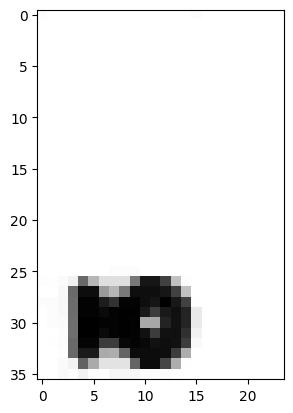

In [12]:
class BlurAugmenter(BaseAugmenter):
    
    def _apply(self, letter, kernel_size=3):
        return cv2.medianBlur(letter, kernel_size)
    
plt.imshow(BlurAugmenter(1)(test), cmap='gray')

In [13]:
class MultipleAugmenter():
    NOISE_CHANCE = 0.8
    NOISE_HARDNESS = 15
    
    FLIP_CHANCE = 0.3
    
    ROTATE_CHANCE = 0.2
    
    BLUR_CHANCE = 0.4
    BLUR_HARD_CHANCE = 0.1
    
    images = []
    captions = []
    
    def __init__(self, images, captions):
        self.images_orig = images
        self.captions_orig = captions
    
    def apply_noise(self, letter):
        noise = np.random.normal(size=(letter.shape))*self.NOISE_HARDNESS
        return letter+noise
    
    def flip(self, letter, mode='horizontal'):
        if mode == 'horizontal':
            return np.flip(letter, axis=0)
        elif mode == 'vertical':
            return np.flip(letter, axis=1)
        elif mode == 'random':
            axis = random.random() < 0.5
            return np.flip(letter, axis=int(axis))
        
    def rotate(self, letter, angle=60):
        image = np.zeros_like(letter) + 255 - letter
        rotated = imutils.rotate_bound(image, angle)
        rotated = np.zeros_like(rotated) + 255 - rotated
        rotated = cv2.resize(rotated, (letter.shape[1], letter.shape[0]))
        return rotated
    
    def blur(self, letter, kernel_size=3):
        img = letter
        try:
            img =  cv2.medianBlur(img, kernel_size)
        except:
            pass
        return img
    
    def random_augment(self, rounds = 1, seed = 42, save_last=False):
        random.seed(seed)
        
        images = self.images_orig
        captions = self.captions_orig
        
        for _ in range(rounds):
            print(len(images))
            num_images = len(images)
            for n in range(num_images):
                image = images[n]
                if random.random() < self.NOISE_CHANCE:
                    images.append(self.apply_noise(image))
                    captions.append(captions[n])
                if random.random() < self.FLIP_CHANCE:
                    images.append(self.flip(image))
                    captions.append(captions[n])
                if random.random() < self.ROTATE_CHANCE:
                    images.append(self.rotate(image, random.randint(-30,30)))
                    captions.append(captions[n])
                if random.random() < self.BLUR_CHANCE:
                    images.append(self.blur(image))
                    captions.append(captions[n])
                if random.random() < self.BLUR_HARD_CHANCE:
                    images.append(self.blur(image, 5))
                    captions.append(captions[n])
            if save_last:
                images = images[num_images:]
                captions = captions[num_images:]
        self.images = images
        self.captions = captions

In [14]:
images = []
captions = []
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
for i in range(1, num_fonts+1):
    for j in range(1, num_letters+1):
        images.append(get_letter(i,j))
        captions.append(captions_base[j-1])

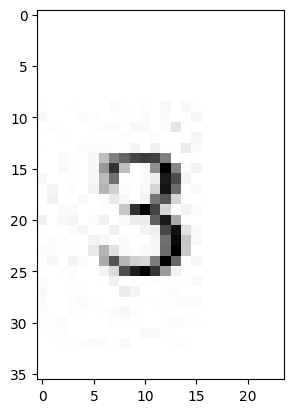

In [15]:
plt.imshow(images[10], cmap='gray')

In [16]:
len(images)

693

In [18]:
aug = MultipleAugmenter(images.copy(), captions.copy())

In [19]:
len(aug.images), len(images)

(0, 693)

In [20]:
aug.random_augment(5)

693
1945
5467
15360
42847


Ь


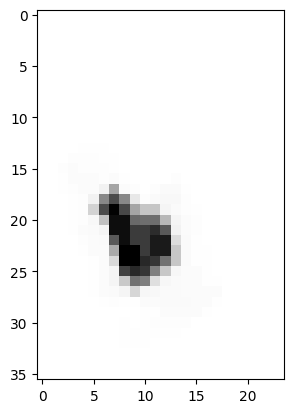

In [21]:
n = 10000
print(aug.captions[n])
plt.imshow(aug.images[n], cmap='gray')

In [22]:
np.array(aug.images).shape[1:]

(36, 24)

# CNN Model

In [23]:
from tensorflow import keras

In [24]:
x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
x_data.shape

(120017, 36, 24, 1)

In [25]:
classes = list(map(captions_base.index, aug.captions))
y_data = keras.utils.to_categorical(classes, num_classes=num_letters)

In [26]:
test_aug = MultipleAugmenter(images.copy(), captions.copy())
test_aug.random_augment(7, 65, True)
len(test_aug.images), len(test_aug.captions)

693
1216
2176
3886
6944
12410
22478


(40429, 40429)

In [27]:
test_x_data = np.array(test_aug.images)
test_x_data = test_x_data.reshape(*test_x_data.shape, 1)

test_classes = list(map(captions_base.index, test_aug.captions))
test_y_data = keras.utils.to_categorical(test_classes, num_classes=num_letters)

In [28]:
inputs = keras.layers.Input(shape=(*np.array(aug.images).shape[1:],1), name='inputs')
conv = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
conv = keras.layers.MaxPool2D()(conv)
conv = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(conv)
conv = keras.layers.MaxPool2D()(conv)
conv = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(conv)
conv = keras.layers.MaxPool2D()(conv)

dense = keras.layers.Flatten()(conv)
dense = keras.layers.Dense(1024, activation='relu')(dense)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
dense = keras.layers.Dense(num_letters, activation='softmax')(dense)

model = keras.models.Model(inputs=inputs, outputs=dense)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 36, 24, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 36, 24, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 18, 12, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 12, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 6, 512)         118016

2024-01-29 11:22:01.478165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 11:22:01.508717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 11:22:01.509040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [29]:
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

In [30]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta = 1e-3,
                              patience=3, min_lr=1e-10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=7)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs")

In [31]:
his = model.fit(x_data, y_data,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_split=0.2,
          callbacks=[reduce_lr, early_stop, tensorboard],
                )

2024-01-29 11:22:21.243551: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 331820928 exceeds 10% of free system memory.
2024-01-29 11:22:21.590144: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 331820928 exceeds 10% of free system memory.


Epoch 1/50


2024-01-29 11:22:21.870044: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-29 11:22:22.882905: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-29 11:22:22.970368: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-29 11:22:23.304876: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1850bfc6c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-29 11:22:23.304900: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-01-29 11:22:23.309583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706516543.383324   11771 devic

751/751 [==============================] - 18s 20ms/step - loss: 1.5805 - categorical_accuracy: 0.6546 - val_loss: 0.6301 - val_categorical_accuracy: 0.8122 - lr: 0.0010
Epoch 2/50
269/751 [=========>....................] - ETA: 8s - loss: 0.3577 - categorical_accuracy: 0.8925

KeyboardInterrupt: 

<Axes: >

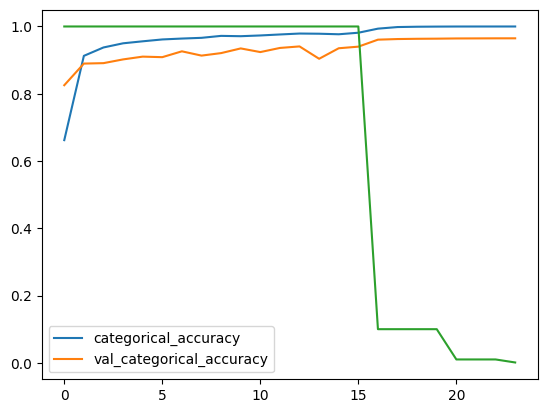

In [31]:
his_df = pd.DataFrame(his.history)
his_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()
(his_df['lr']*1000).plot()

In [32]:
model.evaluate(test_x_data, test_y_data)

1264/1264 [==============================] - 3s 2ms/step - loss: 1.5571 - categorical_accuracy: 0.8034


[1.5570541620254517, 0.8034331798553467]

In [33]:
y_pred = model.predict(test_x_data).argmax(axis=1)
len(y_pred), len(test_classes)

1264/1264 [==============================] - 2s 2ms/step


(40429, 40429)

In [34]:
mat = np.zeros(shape=(num_letters,num_letters))
for i in range(len(y_pred)):
    true_ind = test_classes[i]
    pred_ind = y_pred[i]    
    mat[true_ind, pred_ind]+=1

mat=mat/mat.sum(axis=0)
mat

array([[7.87234043e-01, 1.37681159e-02, 6.98324022e-04, ...,
        0.00000000e+00, 1.09051254e-03, 0.00000000e+00],
       [5.31914894e-03, 7.14492754e-01, 2.16480447e-02, ...,
        0.00000000e+00, 0.00000000e+00, 3.24675325e-03],
       [9.97340426e-03, 3.47826087e-02, 8.41480447e-01, ...,
        0.00000000e+00, 2.18102508e-03, 8.11688312e-04],
       ...,
       [6.64893617e-04, 0.00000000e+00, 3.49162011e-03, ...,
        8.38268793e-01, 1.63576881e-01, 7.30519481e-03],
       [8.64361702e-03, 2.17391304e-03, 6.98324022e-04, ...,
        4.10022779e-02, 7.17557252e-01, 8.11688312e-04],
       [1.99468085e-03, 7.97101449e-03, 6.98324022e-04, ...,
        8.35231587e-03, 1.74482007e-02, 9.32629870e-01]])

Text(0, 0.5, 'Predicted letters')

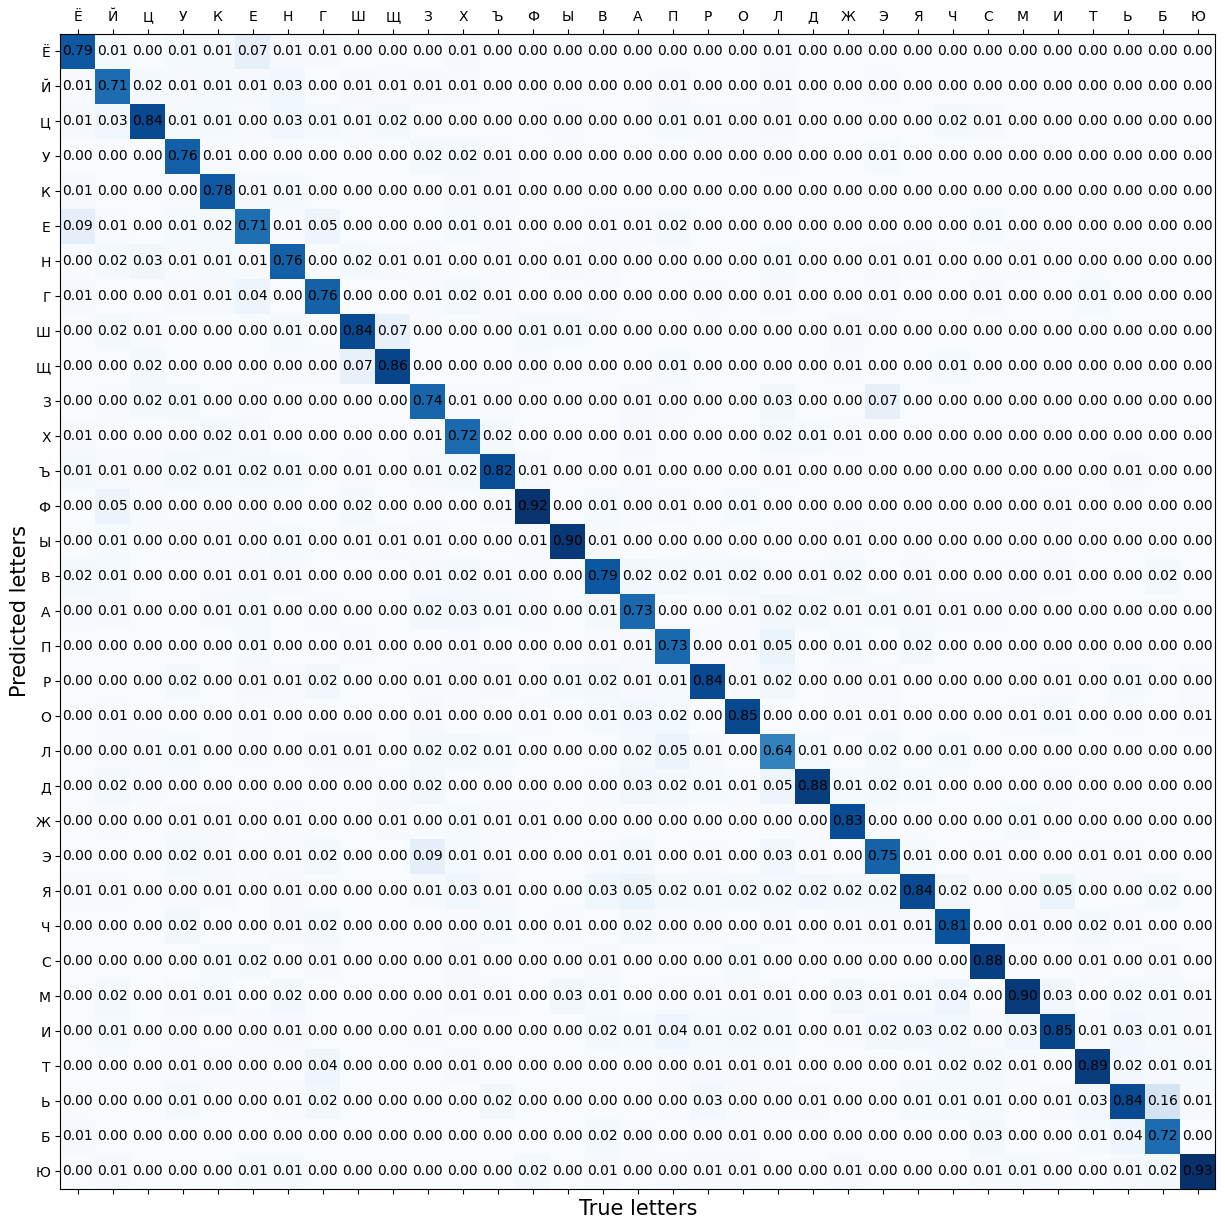

In [35]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(mat, cmap='Blues')
ax.set_xticks(range(len(captions_base)), captions_base)
ax.set_yticks(range(len(captions_base)), captions_base)
for i in range(len(captions_base)):
    for j in range(len(captions_base)):
        c = mat[j,i]
        ax.text(i, j, f'{c:.2f}', va='center', ha='center')
ax.set_xlabel('True letters', fontsize=15)
ax.set_ylabel('Predicted letters', fontsize=15)

1/1 [==============================] - 0s 92ms/step
Р Р


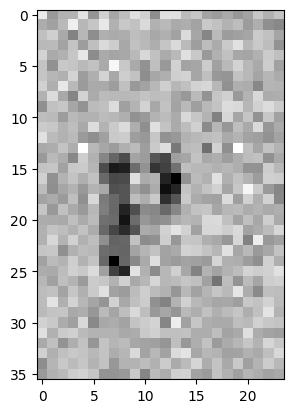

In [36]:
n = 946
img = test_aug.images[n]
print(test_aug.captions[n],captions_base[model.predict(img.reshape((1,*img.shape,1))).argmax()])
plt.imshow(img, cmap='gray')

In [37]:
model.save('models/conv_letter_recognizer.keras')

# Transformer

In [36]:
import keras_nlp

Using TensorFlow backend


In [37]:
inputs = keras.Input(shape=(*np.array(aug.images).shape[1:],1) )
reshaped = keras.layers.Reshape(np.array(aug.images).shape[1:])(inputs)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(reshaped)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(encoded)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(encoded)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(encoded)
dense = keras.layers.Flatten()(encoded)
dense = keras.layers.Dense(1024, activation='relu')(dense)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
outputs = keras.layers.Dense(num_letters, activation='softmax')(dense)


vit_model = keras.Model(inputs=inputs, outputs=outputs)
vit_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 36, 24, 1)]       0         
                                                                 
 reshape (Reshape)           (None, 36, 24)            0         
                                                                 
 transformer_encoder (Trans  (None, 36, 24)            52696     
 formerEncoder)                                                  
                                                                 
 transformer_encoder_1 (Tra  (None, 36, 24)            52696     
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_2 (Tra  (None, 36, 24)            52696     
 nsformerEncoder)                                                
                                                           

In [38]:
vit_model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

In [39]:
his = vit_model.fit(x_data, y_data,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_split=0.2,
          callbacks=[reduce_lr, early_stop, tensorboard],
                )

2024-01-29 11:30:41.856572: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 331820928 exceeds 10% of free system memory.


Epoch 1/50
751/751 [==============================] - 18s 15ms/step - loss: 0.7490 - categorical_accuracy: 0.7823 - val_loss: 0.4645 - val_categorical_accuracy: 0.8665 - lr: 0.0010
Epoch 2/50
751/751 [==============================] - 11s 15ms/step - loss: 0.2127 - categorical_accuracy: 0.9372 - val_loss: 0.3497 - val_categorical_accuracy: 0.8986 - lr: 0.0010
Epoch 3/50
751/751 [==============================] - 11s 14ms/step - loss: 0.1291 - categorical_accuracy: 0.9608 - val_loss: 0.3516 - val_categorical_accuracy: 0.9030 - lr: 0.0010
Epoch 4/50
751/751 [==============================] - 11s 14ms/step - loss: 0.0977 - categorical_accuracy: 0.9705 - val_loss: 0.3231 - val_categorical_accuracy: 0.9125 - lr: 0.0010
Epoch 5/50
751/751 [==============================] - 11s 14ms/step - loss: 0.0764 - categorical_accuracy: 0.9766 - val_loss: 0.2944 - val_categorical_accuracy: 0.9241 - lr: 0.0010
Epoch 6/50
751/751 [==============================] - 11s 14ms/step - loss: 0.0692 - categorica

<Axes: >

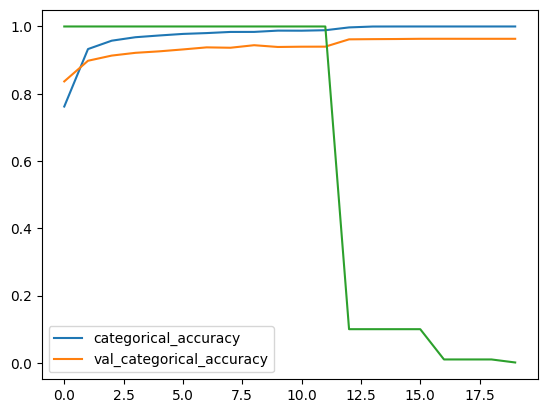

In [42]:
his_df = pd.DataFrame(his.history)
his_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()
(his_df['lr'] * 1000).plot()

In [43]:
vit_model.evaluate(test_x_data, test_y_data), model.evaluate(test_x_data, test_y_data)

1264/1264 [==============================] - 3s 2ms/step - loss: 1.5571 - categorical_accuracy: 0.8034


([1.5126699209213257, 0.7912142276763916],
 [1.5570541620254517, 0.8034331798553467])

1264/1264 [==============================] - 2s 2ms/step


Text(0, 0.5, 'Predicted letters')

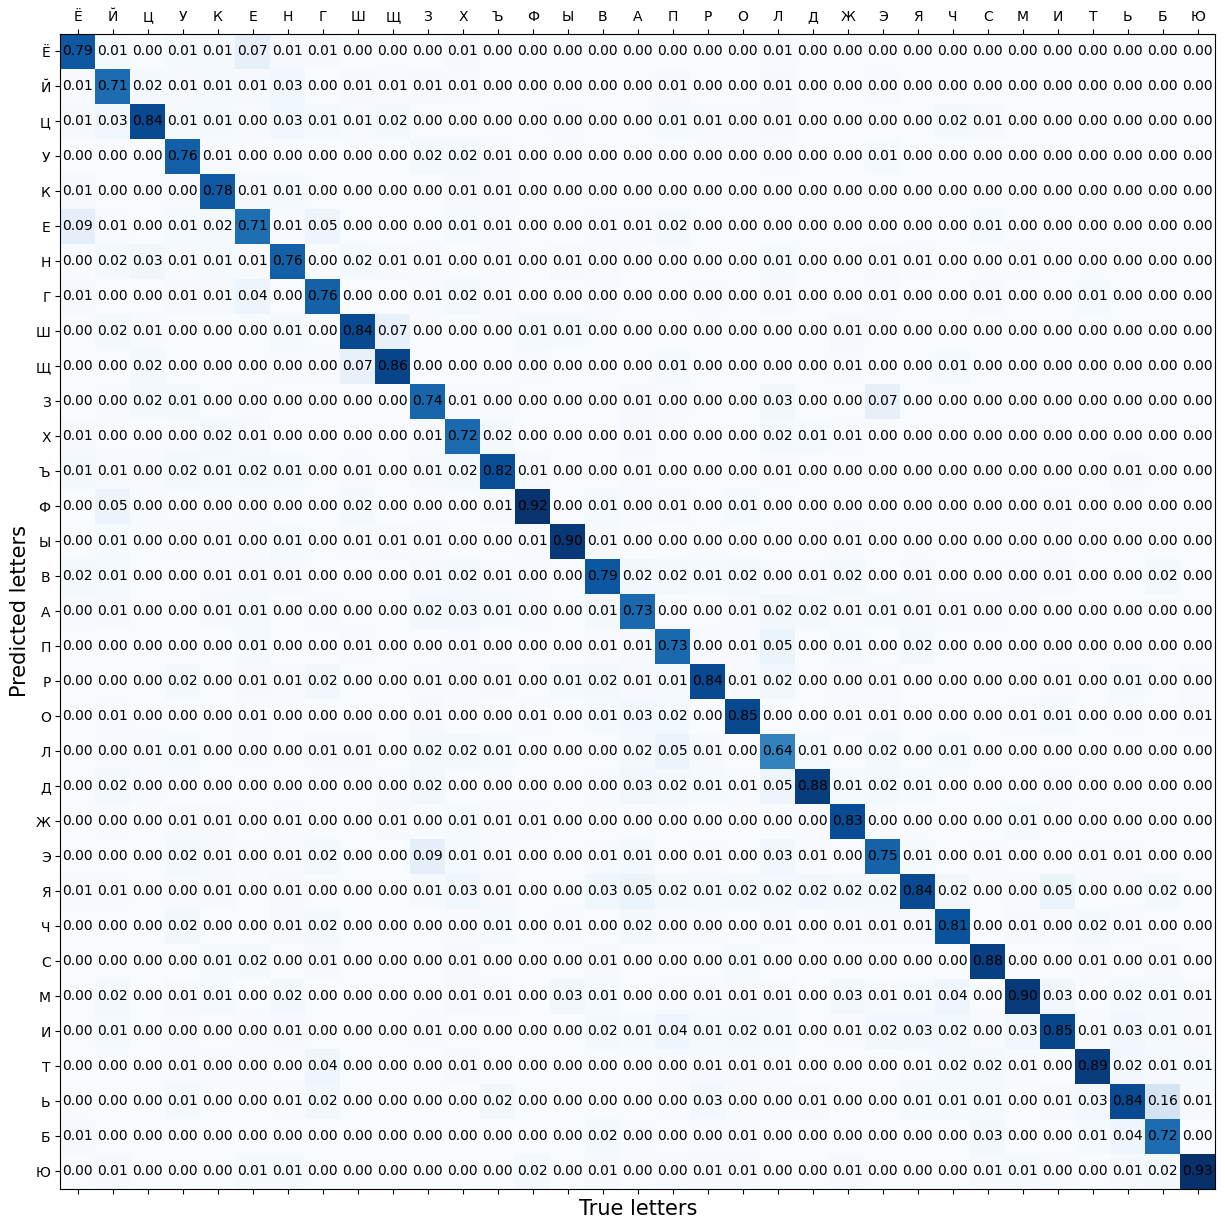

In [44]:
y_pred = model.predict(test_x_data).argmax(axis=1)
mat = np.zeros(shape=(num_letters,num_letters))
for i in range(len(y_pred)):
    true_ind = test_classes[i]
    pred_ind = y_pred[i]    
    mat[true_ind, pred_ind]+=1

mat=mat/mat.sum(axis=0)

fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(mat, cmap='Blues')
ax.set_xticks(range(len(captions_base)), captions_base)
ax.set_yticks(range(len(captions_base)), captions_base)
for i in range(len(captions_base)):
    for j in range(len(captions_base)):
        c = mat[j,i]
        ax.text(i, j, f'{c:.2f}', va='center', ha='center')
ax.set_xlabel('True letters', fontsize=15)
ax.set_ylabel('Predicted letters', fontsize=15)

In [45]:
vit_model.save('models/vit_letter_recognizer.keras')

# LeViT-like

In [32]:
filters = 128

def applyMHA(layer, shrink=False, num_heads=4, key_dim=33):    
    
    if shrink:
        layer_shrinked = keras.layers.MaxPool2D()(layer)
        return keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(layer_shrinked,layer,layer)
    else:
        MHA = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(layer,layer,layer)
        return keras.layers.Add()([layer,MHA])

def addMLP(layer, factor = 2, activation='tanh'):
    MLP = keras.layers.Dense(filters*factor, activation=activation)(layer)
    MLP = keras.layers.Dense(filters, activation=activation)(MLP)    
    return keras.layers.Add()([layer,MLP])
    

In [33]:
inputs = keras.Input(shape=(*np.array(aug.images).shape[1:],1) )
conv = keras.layers.Conv2D(filters=filters, kernel_size=(3,3),strides=2, activation='relu', padding='same')(inputs)
# conv = keras.layers.Conv2D(filters=128, kernel_size=(3,3),strides=3, activation='relu', padding='same')(conv)
block1 = applyMHA(conv)
block1 = addMLP(block1)
block1 = applyMHA(block1)
block1 = addMLP(block1)

block1 = applyMHA(block1, shrink=True, num_heads=16, key_dim=16)

block2 = addMLP(block1)
block2 = applyMHA(block2)
block2 = addMLP(block2)

dense = keras.layers.Flatten()(block2)
dense = keras.layers.Dense(1024, activation='relu')(dense)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
outputs = keras.layers.Dense(num_letters, activation='softmax')(dense)

levit = keras.models.Model(inputs=inputs, outputs=outputs)
levit.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 36, 24, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 18, 12, 128)          1280      ['input_1[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, 18, 12, 128)          68108     ['conv2d_3[0][0]',            
 iHeadAttention)                                                     'conv2d_3[0][0]',            
                                                                     'conv2d_3[0][0]']            
                                                                                            

In [34]:
levit.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

In [35]:
his = levit.fit(x_data, y_data,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_split=0.2,
          callbacks=[reduce_lr, early_stop, tensorboard],
                )

2024-01-29 11:23:00.998894: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 331820928 exceeds 10% of free system memory.
2024-01-29 11:23:01.279034: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 331820928 exceeds 10% of free system memory.


Epoch 1/50
751/751 [==============================] - 69s 85ms/step - loss: 2.2714 - categorical_accuracy: 0.3859 - val_loss: 1.2441 - val_categorical_accuracy: 0.6348 - lr: 0.0010
Epoch 2/50
751/751 [==============================] - 63s 84ms/step - loss: 2.7066 - categorical_accuracy: 0.2909 - val_loss: 3.4919 - val_categorical_accuracy: 0.0389 - lr: 0.0010
Epoch 3/50
751/751 [==============================] - 63s 84ms/step - loss: 3.4923 - categorical_accuracy: 0.0352 - val_loss: 3.4900 - val_categorical_accuracy: 0.0389 - lr: 0.0010
Epoch 4/50
751/751 [==============================] - 63s 84ms/step - loss: 3.4919 - categorical_accuracy: 0.0350 - val_loss: 3.4898 - val_categorical_accuracy: 0.0389 - lr: 0.0010
Epoch 5/50
751/751 [==============================] - 63s 84ms/step - loss: 3.4917 - categorical_accuracy: 0.0352 - val_loss: 3.4897 - val_categorical_accuracy: 0.0389 - lr: 1.0000e-04
Epoch 6/50
751/751 [==============================] - 63s 84ms/step - loss: 3.4917 - catego

KeyboardInterrupt: 

# ViT (like with patches)